In [1]:
from dotenv import load_dotenv

import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

from pathlib import Path

import json

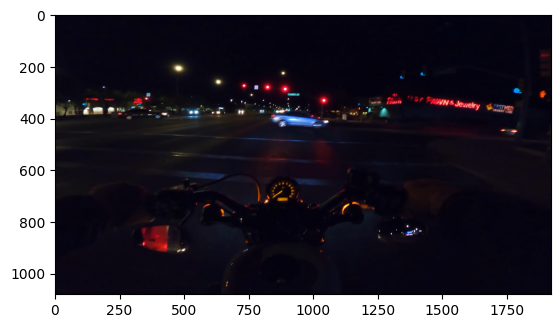

In [2]:
class PathManager:
    """환경 및 모듈 간 규격 클래스"""
    """상황에 맞게 경로와 규격을 수정 후 사용할 것"""
    
    def __init__(self, default_size: int | None = None):
        """dotenv 위치 찾기 + 로드"""
        self.root_path = self._find_root()
        self.dotenv_path = self.root_path / ".env" # 또는 self.dotenv_path = self.root_path / ".env"
        load_dotenv(self.dotenv_path)

        """이미지와 모델 디렉토리 인식"""
        self._images_dir = self.root_path / "data/images"
        self._models_dir = self.root_path / "models"
        self._datas_dir = self.root_path / "data"
        self.default_size = default_size

        self.image_name = None
        self.model_name = None

    def _find_root(self, marker: str=".env") -> Path: # 외부에서 호출할 일 없다.
        """프로젝트 최상단 경로를 찾는 함수"""
        """.env를 마커로 사용"""
        current_cwd = Path().cwd().resolve()
        for parent in current_cwd.parents:
            if (parent / marker).exists():
                return parent

    def get_image_path(self, image_name: str) -> Path:
        """이미지 주소 획득"""
        self.image_name = image_name
        return self._images_dir / image_name
        
    def get_model_path(self, model_name: str) -> Path:
        """모델 주소 획득"""
        self.model_name = model_name
        return self._models_dir / model_name

    def get_data_path(self, data_name: str) -> Path:
        """데이터 주소 획득"""
        self.data_name = data_name
        return self._datas_dir / data_name

def run():
    path_manager = PathManager()

    #
    root_path = path_manager.root_path
    images_dir = path_manager._images_dir
    datas_dir = path_manager._datas_dir


    # 이미지 경로
    my_image_path = path_manager.get_image_path("night ride (7).png")
    # 원본
    my_image_origin = cv2.imread(my_image_path)
    # 원본을 rgb로 변환 후 변수 저장
    my_image_rgb = cv2.cvtColor(my_image_origin, cv2.COLOR_BGR2RGB)

    my_json_path = path_manager.get_data_path("COCO_motorcycle (pixel).json")

    with open (my_json_path, "r", encoding="utf-8") as f:
        my_json_origin = json.load(f)

    # 시각화
    plt.imshow(my_image_rgb)
    plt.show

    return root_path, images_dir, datas_dir, my_json_origin

root_path, images_dir, datas_dir, my_json_origin = run()

In [3]:
import os

# 1. 실제 폴더에 있는 이미지 파일 목록
folder_images = set(os.listdir(images_dir))

# 2. JSON 장부에 적혀 있는 이미지 파일 목록
json_images = {img['file_name'] for img in my_json_origin['images']}

# 3. 교집합 확인 (둘 다 있는 것들)
valid_images = folder_images.intersection(json_images)

# 4. 결과 보고
print(f"폴더 내 파일 수: {len(folder_images)}")
print(f"JSON 내 파일 수: {len(json_images)}")
print(f"최종 매칭된 파일 수: {len(valid_images)}")

# 결측치 확인
missing_in_json = folder_images - json_images
print(f"JSON에 정보가 없는 이미지 (예: (7)번): {missing_in_json}")

폴더 내 파일 수: 600
JSON 내 파일 수: 200
최종 매칭된 파일 수: 200
JSON에 정보가 없는 이미지 (예: (7)번): {'night ride (75).png___fuse.png', 'Screenshot (358).png___fuse.png', 'Screenshot (446).png___save.png', 'Screenshot (418).png___fuse.png', 'night ride (53).png___save.png', 'Screenshot (427).png___save.png', 'Screenshot (395).png___fuse.png', 'night ride (45).png___save.png', 'night ride (70).png___save.png', 'night ride (51).png___save.png', 'night ride (24).png___save.png', 'Screenshot (426).png___save.png', 'Screenshot (444).png___save.png', 'night ride (96).png___save.png', 'Screenshot (391).png___fuse.png', 'Screenshot (394).png___save.png', 'night ride (48).png___fuse.png', 'night ride (97).png___fuse.png', 'Screenshot (384).png___fuse.png', 'night ride (97).png___save.png', 'night ride (56).png___save.png', 'night ride (77).png___fuse.png', 'night ride (40).png___fuse.png', 'Screenshot (439).png___fuse.png', 'night ride (44).png___save.png', 'Screenshot (422).png___fuse.png', 'Screenshot (414).png___sa

In [ ]:
# 파일명을 넣으면 ID를 바로 알려주는 사전 생성 (순서 무시)
filename_to_id = {img['file_name']: img['id'] for img in my_json_origin['images']}

# 이제 (7)번 파일의 ID가 궁금하면?
target_id = filename_to_id.get("night ride (101).png")
print(f"(7)번의 실제 ID는 {target_id}입니다.") # 결과: 11

# for result in range(7, 2)

(7)번의 실제 ID는 None입니다.


In [23]:
import os

# 1. JSON 장부에 적힌 이름들 (night ride든 Screenshot이든 상관없이 다 수집)
json_filenames = {img['file_name'] for img in my_json_origin['images']}

# 2. 폴더 내 실물 파일들 중 찌꺼기(___fuse, ___save) 제외하고 순수 원본만 추출
folder_files = [f for f in os.listdir(images_dir) if "___" not in f]

# 3. 교집합 확인 (이름이 완벽히 일치하는 놈들만)
valid_list = [f for f in folder_files if f in json_filenames]

print(f"✅ 총 {len(valid_list)}장의 원본이 장부와 일치합니다.")
print(f"❌ 매칭 실패(유령 파일): {len(folder_files) - len(valid_list)}개")

✅ 총 200장의 원본이 장부와 일치합니다.
❌ 매칭 실패(유령 파일): 0개


In [24]:
import random
from sklearn.model_selection import train_test_split

# 1. 재현성을 위해 시드 고정 (매번 섞이는 결과가 같아야 함)
random.seed(42)

# 2. 전체 데이터 분할 (Train+Val 90% : Test 10%)
train_val_files, test_files = train_test_split(
    valid_list, test_size=0.1, random_state=42, shuffle=True
)

# 3. Train+Val을 다시 분할 (Train 80% : Val 10% - 전체 대비 비율)
# 180장 중 20장을 뽑아야 하므로 test_size는 약 0.111
train_files, val_files = train_test_split(
    train_val_files, test_size=0.111, random_state=42, shuffle=True
)

print(f"📊 최종 분할 결과:")
print(f" - Train: {len(train_files)}장")
print(f" - Val: {len(val_files)}장")
print(f" - Test: {len(test_files)}장")

📊 최종 분할 결과:
 - Train: 160장
 - Val: 20장
 - Test: 20장


In [38]:
train_files[0]

'night ride (54).png'

In [40]:
path_manager = PathManager()

train_image_paths = [path_manager.get_image_path(f) for f in train_files]

train_image_paths

[WindowsPath('C:/Users/ADMIN/Documents/projects/team/Dlthon_01_Motocycle_Night_Ride/data/images/night ride (54).png'),
 WindowsPath('C:/Users/ADMIN/Documents/projects/team/Dlthon_01_Motocycle_Night_Ride/data/images/Screenshot (431).png'),
 WindowsPath('C:/Users/ADMIN/Documents/projects/team/Dlthon_01_Motocycle_Night_Ride/data/images/Screenshot (434).png'),
 WindowsPath('C:/Users/ADMIN/Documents/projects/team/Dlthon_01_Motocycle_Night_Ride/data/images/Screenshot (359).png'),
 WindowsPath('C:/Users/ADMIN/Documents/projects/team/Dlthon_01_Motocycle_Night_Ride/data/images/Screenshot (379).png'),
 WindowsPath('C:/Users/ADMIN/Documents/projects/team/Dlthon_01_Motocycle_Night_Ride/data/images/night ride (29).png'),
 WindowsPath('C:/Users/ADMIN/Documents/projects/team/Dlthon_01_Motocycle_Night_Ride/data/images/night ride (11).png'),
 WindowsPath('C:/Users/ADMIN/Documents/projects/team/Dlthon_01_Motocycle_Night_Ride/data/images/Screenshot (414).png'),
 WindowsPath('C:/Users/ADMIN/Documents/proj

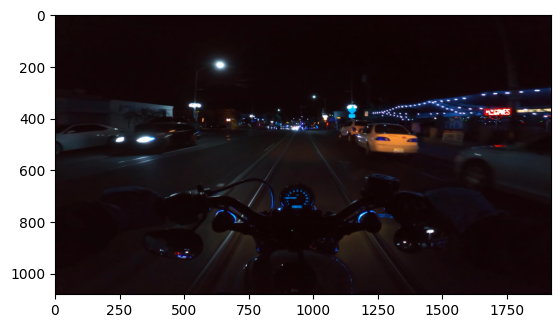

In [54]:
test_image = cv2.imread(train_image_paths[0])
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image)
plt.show()

#### 모델 정의

In [64]:
import os
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights

# 장치 설정 (GPU 사용 가능 여부 확인)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [65]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
if torch.cuda.is_available():
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0+cpu
CUDA available: False
CUDA version: None


In [ ]:
# 모델 불러오기 (사전학습 가중치 포함)
model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)

# 마지막 출력 레이어 강제 교체 (21개 -> 7개)
model.classifier[4] = nn.Conv2d(256, 7, kernel_size=(1, 1))

# 보조 출력 레이어도 7개로 교체 (학습 안정성을 위해 필요)
if model.aux_classifier:
    model.aux_classifier[4] = nn.Conv2d(256, 7, kernel_size=(1, 1))

model.to(device)

# 손실함수와 최적화 도구 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
#### 데이터셋

: 

In [ ]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np

class NightRideDataset(Dataset):
    def __init__(self, image_paths, json_data, target_size=(512, 512)):
        self.image_paths = image_paths
        self.json_data = json_data
        self.target_size = target_size
        
        # 속도 최적화를 위한 인덱싱
        self.filename_to_id = {img['file_name']: img['id'] for img in json_data['images']}
        from collections import defaultdict
        self.id_to_anns = defaultdict(list)
        for ann in json_data['annotations']:
            self.id_to_anns[ann['image_id']].append(ann)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 1. 이미지 로드 및 리사이즈
        img_path = self.image_paths[idx]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h_orig, w_orig = image.shape[:2]
        
        # 2. 마스크 생성 (배경 0으로 초기화)
        mask = np.zeros((h_orig, w_orig), dtype=np.uint8)
        img_id = self.filename_to_id[img_path.name]
        for ann in self.id_to_anns.get(img_id, []):
            cat_id = ann['category_id'] - 1  # 0~6 범위로 조정
            for seg in ann['segmentation']:
                poly = np.array(seg).reshape(-1, 2).astype(np.int32)
                cv2.fillPoly(mask, [poly], int(cat_id))

        # 3. 리사이징 (이미지는 선형, 마스크는 최근접 이웃 보간법)
        image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)

        # 4. 텐서 변환 및 정규화
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        mask = torch.from_numpy(mask).long()
        
        return image, mask

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# 1. 장치 설정 (반드시 GPU 환경 구축 후 실행!)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. 모델 정의
model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)
model.classifier[4] = nn.Conv2d(256, 7, kernel_size=(1, 1))
if model.aux_classifier:
    model.aux_classifier[4] = nn.Conv2d(256, 7, kernel_size=(1, 1))
model.to(device)

# 3. 데이터 로더 구성
train_ds = NightRideDataset(train_image_paths, my_json_origin)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)

# 4. 손실함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [55]:
model = deeplabv3_resnet101(pretrained=True).eval()

c:\Users\ADMIN\Documents\projects\team\Dlthon_01_Motocycle_Night_Ride\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\Documents\projects\team\Dlthon_01_Motocycle_Night_Ride\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기 (고정)
    T.ToTensor(),
])

In [57]:
input_tensor = transform(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)).unsqueeze(0)
input_tensor

tensor([[[[0.0353, 0.0353, 0.0353,  ..., 0.0275, 0.0275, 0.0275],
          [0.0353, 0.0353, 0.0353,  ..., 0.0275, 0.0275, 0.0275],
          [0.0353, 0.0353, 0.0353,  ..., 0.0275, 0.0275, 0.0275],
          ...,
          [0.0588, 0.0588, 0.0510,  ..., 0.0314, 0.0314, 0.0314],
          [0.0588, 0.0588, 0.0510,  ..., 0.0392, 0.0392, 0.0392],
          [0.0510, 0.0510, 0.0431,  ..., 0.0314, 0.0314, 0.0314]],

         [[0.0314, 0.0314, 0.0314,  ..., 0.0196, 0.0196, 0.0196],
          [0.0314, 0.0314, 0.0314,  ..., 0.0196, 0.0196, 0.0196],
          [0.0314, 0.0314, 0.0314,  ..., 0.0196, 0.0196, 0.0196],
          ...,
          [0.0353, 0.0353, 0.0392,  ..., 0.0196, 0.0196, 0.0196],
          [0.0353, 0.0353, 0.0392,  ..., 0.0235, 0.0235, 0.0235],
          [0.0275, 0.0275, 0.0314,  ..., 0.0157, 0.0157, 0.0157]],

         [[0.0824, 0.0824, 0.0824,  ..., 0.0745, 0.0745, 0.0745],
          [0.0824, 0.0824, 0.0824,  ..., 0.0745, 0.0745, 0.0745],
          [0.0824, 0.0824, 0.0824,  ..., 0

In [ ]:
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (test_image.shape[1], test_image.shape[0]), interpolation=cv2.INTER_NEAREST)

CPU times: total: 7.12 s
Wall time: 1.22 s


In [63]:
output_predictions_resized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1080, 1920), dtype=uint8)

In [41]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np

class NightRideDataset(Dataset):
    def __init__(self, image_paths, json_data, transform=None):
        self.image_paths = image_paths
        self.json_data = json_data
        self.transform = transform
        # 파일명을 키로, 어노테이션을 값으로 하는 사전 생성 (속도 최적화)
        self.img_to_ann = {img['file_name']: img['id'] for img in json_data['images']}
        self.ann_map = self._get_ann_map()

    def _get_ann_map(self):
        # 이미지 ID별로 어노테이션 묶기
        from collections import defaultdict
        mapping = defaultdict(list)
        for ann in self.json_data['annotations']:
            mapping[ann['image_id']].append(ann)
        return mapping

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 1. 이미지 로드
        img_path = self.image_paths[idx]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # 2. 마스크 생성 (여기에 좌표를 픽셀로 그리는 로직이 들어감)
        # 3. Transform 적용
        # 4. Return image, mask
        pass

In [44]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np

class NightRideDataset(Dataset):
    def __init__(self, image_paths, json_data, transform=None):
        """
        Args:
            image_paths (list): PathManager로 얻은 WindowsPath 리스트
            json_data (dict): json.load()로 읽은 원본 데이터
            transform: Albumentations 등 이미지 증강 라이브러리 (선택)
        """
        self.image_paths = image_paths
        self.json_data = json_data
        self.transform = transform
        
        # 속도 최적화: 파일명을 키로 하여 이미지 ID를 즉시 찾는 사전 생성
        self.filename_to_id = {img['file_name']: img['id'] for img in json_data['images']}
        
        # 속도 최적화: 이미지 ID별로 어노테이션(정답)들을 미리 묶어둠
        from collections import defaultdict
        self.id_to_anns = defaultdict(list)
        for ann in json_data['annotations']:
            self.id_to_anns[ann['image_id']].append(ann)

    def __len__(self):
        return len(self.image_paths)

    def _get_mask(self, image_id, height, width):
        """JSON 좌표를 바탕으로 0과 1로 구성된 마스크 생성"""
        # 도화지 생성 (배경은 0)
        mask = np.zeros((height, width), dtype=np.uint8)
        
        annotations = self.id_to_anns.get(image_id, [])
        for ann in annotations:
            # segmentation 좌표 추출 (x1, y1, x2, y2...)
            for seg in ann['segmentation']:
                poly = np.array(seg).reshape(-1, 2).astype(np.int32)
                # 다각형 내부를 1(정답 클래스)로 채움
                cv2.fillPoly(mask, [poly], 1)
        return mask

    def __getitem__(self, idx):
        # 1. 원본 로드
        img_path = self.image_paths[idx]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        file_name = img_path.name
        image_id = self.filename_to_id[file_name]
        h, w, _ = image.shape
        mask = self._get_mask(image_id, h, w)
        
        # 2. 리사이징 적용 (512, 512)
        # 이미지는 INTER_LINEAR, 마스크는 INTER_NEAREST(값 왜곡 방지) 권장
        target_size = (512, 512)
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        
        # 3. 텐서 변환
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        mask = torch.from_numpy(mask).long()

        return image, mask

In [48]:
# 훈련 데이터셋 인스턴스 생성
train_dataset = NightRideDataset(train_image_paths, my_json_origin)

# 첫 번째 데이터 꺼내기
sample_img, sample_mask = train_dataset[0]

print(f"이미지 텐서 크기: {sample_img.shape}") # [3, H, W]
print(f"마스크 텐서 크기: {sample_mask.shape}") # [H, W]
print(f"마스크 고유값(클래스): {torch.unique(sample_mask)}") # [0, 1] 이 나와야 함

이미지 텐서 크기: torch.Size([3, 512, 512])
마스크 텐서 크기: torch.Size([512, 512])
마스크 고유값(클래스): tensor([1])


In [49]:
# 마스크 내의 0과 1의 개수를 세어봅니다.
zero_count = (sample_mask == 0).sum().item()
one_count = (sample_mask == 1).sum().item()

print(f"배경(0) 픽셀 수: {zero_count}")
print(f"오토바이(1) 픽셀 수: {one_count}")

if zero_count == 0:
    print("🚨 경고: 배경이 아예 없습니다! 마스크 생성 로직을 점검하세요.")

배경(0) 픽셀 수: 0
오토바이(1) 픽셀 수: 262144
🚨 경고: 배경이 아예 없습니다! 마스크 생성 로직을 점검하세요.


In [ ]:
# 클래스 내부의 self.file_list가 
# 외부의 train_files(리스트)를 받아 저장하는 시점입니다.

train_dataset = VisionDataset(
    file_list=train_files,      # <--- 여기서 정의된 변수를 넘겨줌
    images_dir=images_dir,
    json_data=my_json_origin
)

In [29]:
# 전체를 부르지 말고 딱 첫 번째 샘플만 확인
sample_img, sample_label = train_dataset[0]

print(type(sample_img))   # <class 'PIL.Image.Image'> -> 실물 확인
print(sample_label)       # {'id': ...} -> 정보 확인

# 실물을 눈으로 직접 보고 싶다면
sample_img.show()

<class 'PIL.Image.Image'>
{'id': 42, 'file_name': 'night ride (54).png', 'height': 1080, 'width': 1920, 'license': 1}


In [30]:
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, file_list, images_dir, masks_dir, transform=None):
        self.file_list = file_list
        self.images_dir = images_dir
        self.masks_dir = masks_dir  # 마스크 파일이 저장된 경로 필요
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        img_path = os.path.join(self.images_dir, file_name)
        # 마스크 파일명 규칙에 따라 경로 설정 (예: .png)
        mask_path = os.path.join(self.masks_dir, file_name.replace(".jpg", ".png"))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # 0~255 클래스 인덱스

        if self.transform:
            # 이미지와 마스크를 동시에 변환해야 함 (중요)
            image, mask = self.transform(image, mask)

        return image, mask

In [31]:
from torchvision.models.segmentation import deeplabv3_resnet101

# 클래스 개수(배경 포함)를 지정해야 합니다. 예: 21개(PASCAL VOC 기준)
num_classes = 2 

model = deeplabv3_resnet101(weights='DEFAULT')
# 최종 출력 레이어를 프로젝트의 클래스 개수에 맞게 변경
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1))

# DeepLabV3는 보조 출력이 있는 경우가 많으므로 확인 필요
if model.aux_classifier:
    model.aux_classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1))

model.to('cuda' if torch.cuda.is_available() else 'cpu')

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se